In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def EA2MA(EA, e):
    MA = EA - e*np.sin(EA)
    return MA

def MA2EA(MA, e):
    bounds = [(0, 2*np.pi)]
    init_guess = MA
    best_fit = minimize(lambda x: np.abs(MA - EA2MA(x, e)), init_guess, bounds=bounds)
    EA = best_fit['x'][0]
    return EA

def EA2TA(EA, e):
    arg_num = np.sqrt(1+e)*np.sin(EA/2)
    arg_denom = np.sqrt(1-e)*np.cos(EA/2)
    TA = 2*np.arctan2(arg_num, arg_denom)
    return TA

def MA2TA(MA, e):
    TA = EA2TA(MA2EA(MA, e), e)
    return TA

We want to verify that the initial phase of the harmonics is indeed what we believe.

In [26]:
# Generate harmonics
all_wfs = get_h([1]*15, 10, 0.3, chirp2total(15, 2), 2, 4096)
h0, h1, hn1, h2 = all_wfs[1:5]

matches = []
MA_vals = np.linspace(0, 2*np.pi, 16, endpoint=False)
for MA in MA_vals:
    s_f_max = shifted_f(10, 0.3, chirp2total(15, 2), 2)
    s_f_2pi = 10 - s_f_max
    s_f = 10 - s_f_2pi*(MA/(2*np.pi))
    s_e = shifted_e(s_f, 10, 0.3)

    # Generate 'data' waveform
    data = gen_wf(s_f, s_e, chirp2total(15, 2), 2, 4096, 'TEOBResumS', phase=0)

    # Calculate overlaps
    matches.append(match_hn(all_wfs[1:5], data, 10))
matches = np.array(matches)

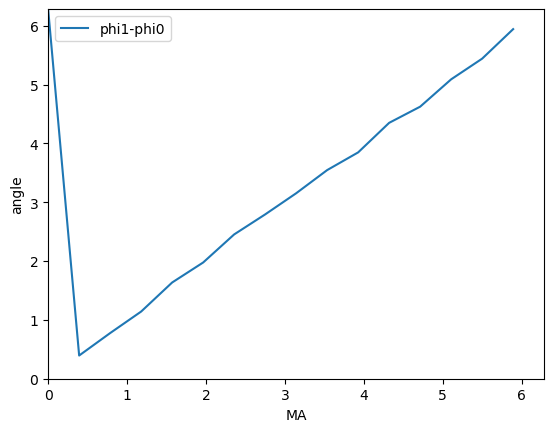

In [30]:
phi0 = np.angle(matches[:,0])
phi1 = np.angle(matches[:,1])
phin1 = np.angle(matches[:,2])

diff1 = (phi1-phi0)%(2*np.pi)
diff2 = (phi0-phin1)%(2*np.pi)
avg_diff = ((diff1+diff2)/2)%(2*np.pi)

plt.plot(MA_vals, diff1, label='phi1-phi0')
# plt.plot(MA_vals, diff2, label='phi0-phin1')
# plt.plot(MA_vals, avg_diff, label='avg (phi1-phin1)/2')
plt.xlabel('MA')
plt.ylabel('angle')
plt.xlim(0, 2*np.pi)
plt.ylim(0, 2*np.pi)
plt.legend()

Text(0, 0.5, 'Imaginary')

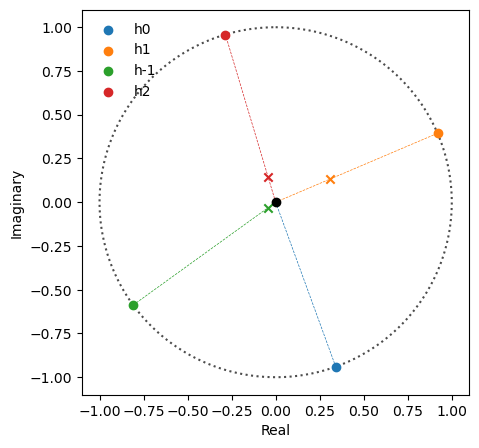

In [5]:
# Generate 'data' waveform
data = gen_wf(10, 0.3, chirp2total(15, 2), 2, 4096, 'TEOBResumS', TA=np.pi+MA2TA(np.pi/2, 0.3), phase=0)

# Generate harmonics
all_wfs = get_h([1]*15, 10, 0.3, chirp2total(15, 2), 2, 4096)
h0, h1, hn1, h2 = all_wfs[1:5]

# Calculate overlaps
match_cplx = match_hn(all_wfs[1:5], data, 10)

# Plot figure
plt.figure(figsize=(5,5))
theta = np.linspace(0, 2*np.pi, 1000, endpoint=False)
plt.plot(np.sin(theta), np.cos(theta), c='k', ls='dotted', alpha=0.7, zorder=-1)
plt.scatter(0, 0, c='k')
labels= ['h0', 'h1', 'h-1', 'h2']
for i, SNR in enumerate(match_cplx):
    plt.scatter(np.real(SNR)/np.abs(SNR), np.imag(SNR)/np.abs(SNR), c=f'C{i}', label=labels[i])
    plt.plot([0, np.real(SNR)]/np.abs(SNR), [0, np.imag(SNR)]/np.abs(SNR), c=f'C{i}', lw=0.5, ls='dashed', zorder=-1)
    if i > 0:
        plt.scatter(np.real(SNR)/np.abs(match_cplx[0]), np.imag(SNR)/np.abs(match_cplx[0]), c=f'C{i}', marker='x', zorder=-1)
plt.legend(frameon=False, loc='upper left')
plt.xlabel('Real')
plt.ylabel('Imaginary')

Playing around, seems pretty clear that the difference in phase between h-1, h0, h1, etc. is actually given by mean anomaly rather than true anomaly.

When we generate our harmonics we set all their initial phases to be the same (or alternatively have zero initial mean anomaly). Therefore when matching with the real harmonics contained in a signal, all the phase of the match arises from the phases of these real harmonics. There is some 'offset' in the matches relating to the overall phase difference between the data and the signal, however the mean anomaly should be well recovered.

It therefore seems reasonable to say that the phase is equal to

$$
\Phi_0 = 2 \tilde{\gamma}_0 + (2+k) l_0.
$$

For data and our harmonics with non-identical parameters, the binary will have evolved from the start point of (one of) the waveforms before the match 'starts', and so the measured value of mean anomaly will be different to that inputted into the waveform. As a consequence, this seems to make it rather tricky to measure the physical value of the anomaly of a signal using this method - would likely be quite large uncertainties arising.